In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from snorkel.learning.pytorch import LSTM
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
dotenv.load_dotenv('../env.sh')
%matplotlib inline
%run ../src/supervision.py
session = SnorkelSession()

In [15]:
classes = get_candidate_classes()
candidate_class = classes.inducing_cytokine
#candidate_class = classes.secreted_cytokine
X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == 0).all()
len(X)

11735

In [16]:
lstm = LSTM()
path = osp.join(os.environ['MODEL_DATA_DIR'], 'lstm')
lstm.load('lstm_' + candidate_class.field, path)

[LSTM] Loaded model <lstm_inducing_cytokine>


In [17]:
Y = lstm.marginals(X)
Y.shape

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(11735,)

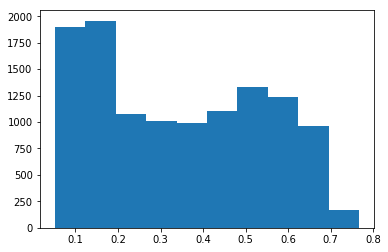

In [18]:
plt.hist(Y)
None

In [19]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

In [20]:
df_ck = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cytokines.csv'))
df_ct = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cell_types.csv'))
m_ct, m_ck = df_ct.set_index('prefid')['lbl'].to_dict(), df_ck.set_index('prefid')['lbl'].to_dict()

In [21]:
assert len(X) == len(Y)
def to_record(c, i):
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == ENT_TYP_CK.lower():
        m1 = m_ck
    ent1_cid = getattr(c, typs[0] + '_cid')
    ent2_cid = getattr(c, typs[1] + '_cid')
    return {
        'type': candidate_class.field, 
        'doc_id': c.get_parent().get_parent().name, 
        'candidate_id': c.id, 
        'ent1_text': getattr(c, typs[0]).get_span(),
        'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
        'ent1_cid': ent1_cid, 
        'ent2_text': getattr(c, typs[1]).get_span(),
        'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
        'ent2_cid': ent2_cid,
        'prob': Y[i]
    }

df = pd.DataFrame([to_record(c, i) for i, c in enumerate(X)])
df.head()

,candidate_id,doc_id,ent1_cid,ent1_lbl,ent1_text,ent2_cid,ent2_lbl,ent2_text,prob,type
0,1,PMC3376453,CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707,IL-4,IL-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.689861,inducing_cytokine
1,2,PMC5321676,CK8074B95EB01901B1:CK128EC732B281BF60,IFN-γ,IFNγ,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.378053,inducing_cytokine
2,3,PMC6083814,CKA197B6F7EC55F6D2:CK3FDAFD137F96385F,IL-22,IL-21,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.702274,inducing_cytokine
3,4,PMC6083814,CKA197B6F7EC55F6D2:CK3FDAFD137F96385F,IL-22,IL-21,CTBFBDE5121B6748D1:CTBFBDE5121B6748D1,Th17,Th17,0.702124,inducing_cytokine
4,5,PMC4183221,CK82326B8893D0ED95:CKFD4CA0B2B4BC3AE4,TGF-β,TGF–β,CT954E3C2D0B390922:CTE9F6070561C95355,Tfh,TFH,0.566213,inducing_cytokine


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11735 entries, 0 to 11734
Data columns (total 10 columns):
candidate_id    11735 non-null int64
doc_id          11735 non-null object
ent1_cid        11735 non-null object
ent1_lbl        11735 non-null object
ent1_text       11735 non-null object
ent2_cid        11735 non-null object
ent2_lbl        11735 non-null object
ent2_text       11735 non-null object
prob            11735 non-null float64
type            11735 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 916.9+ KB


In [23]:
#df.groupby(['ent2_lbl', 'ent1_lbl'])['prob'].describe().sort_values('mean')

In [24]:
df['ent2_lbl'].value_counts().sort_values().tail()

Th       620
Treg    1615
Th2     1878
Th1     1981
Th17    2852
Name: ent2_lbl, dtype: int64

In [25]:
df['ent1_lbl'].value_counts().sort_values().tail()

IL-2      755
IL-10     940
IL-4     1275
TGF-β    1331
IFN-γ    1412
Name: ent1_lbl, dtype: int64

In [13]:
# (
#     df
#     .groupby(['ent2_lbl', 'ent1_lbl'])['prob'].agg(['count', 'mean']).reset_index()
#     .query('count > 10')
#     .sort_values('count', ascending=False)
#     .query('ent2_lbl == "Th1"')
#     .head(25)
# )

In [26]:
dfp = (
    df.query('prob > .5')
    .groupby(['ent2_lbl', 'ent1_lbl'])['prob'].agg(['count', 'mean']).reset_index()
    .query('count > 10')
    .groupby('ent2_lbl', group_keys=False).apply(lambda g: g.sort_values('count', ascending=False).head(15))
)
dfp.head()

,ent2_lbl,ent1_lbl,count,mean
36,TMEM,IL-15,12,0.612676
71,TN,TGF-β,14,0.609418
87,Tc9,IL-9,36,0.566796
111,Tfh,TGF-β,40,0.620134
99,Tfh,IL-21,25,0.591494


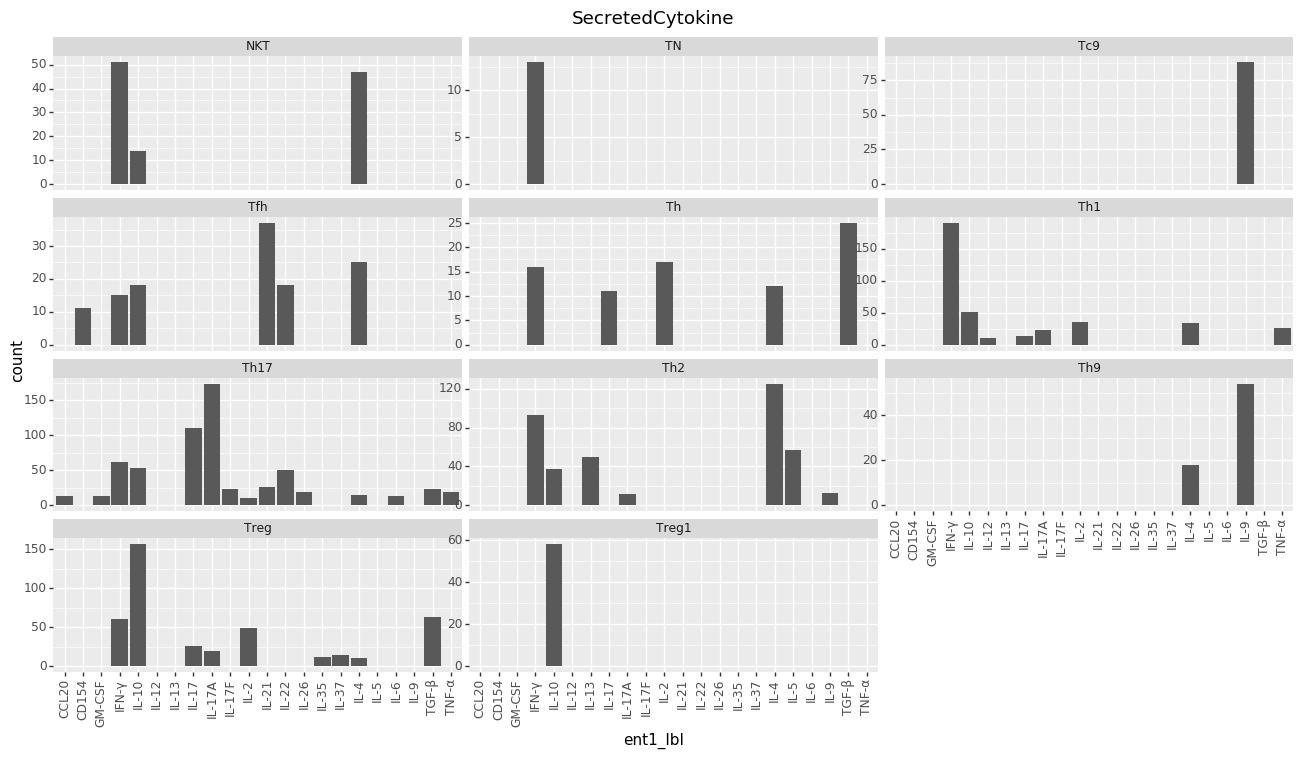

<ggplot: (-9223372036551896979)>

In [14]:
(
    pn.ggplot(dfp, pn.aes(x='ent1_lbl', y='count')) + 
    pn.geom_bar(stat='identity') +
    pn.facet_wrap('~ ent2_lbl', scales='free_y', ncol=3) + 
    pn.labs(title=candidate_class.name) + 
    pn.theme(
        axis_text_x = pn.element_text(angle = 90, hjust = .5),
        figure_size=(16,8)
    )
)

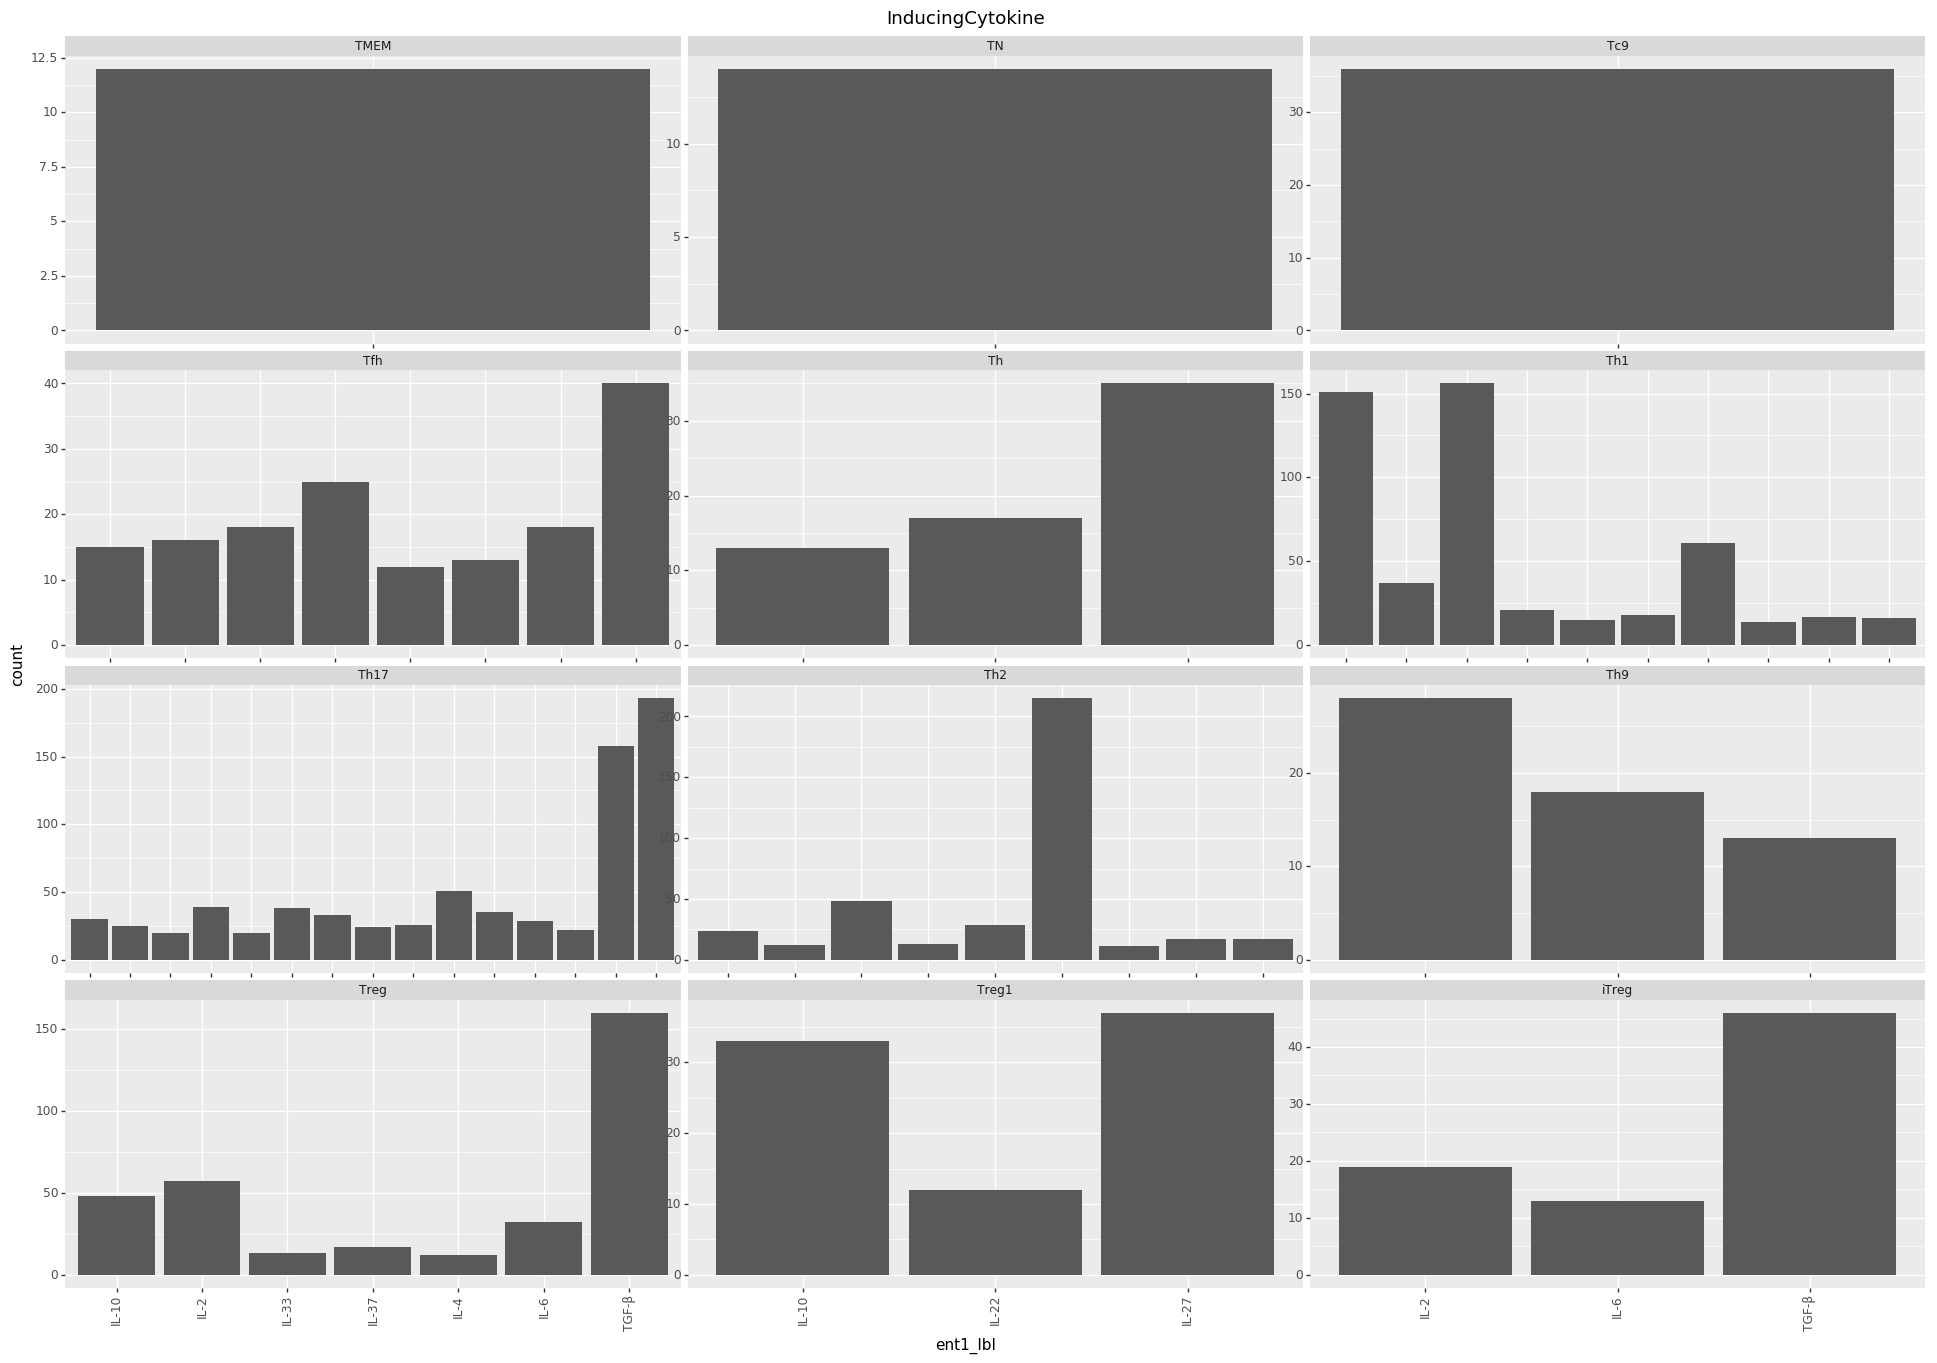

<ggplot: (-9223372036527909495)>

In [29]:
(
    pn.ggplot(dfp, pn.aes(x='ent1_lbl', y='count')) + 
    pn.geom_bar(stat='identity') +
    pn.facet_wrap('~ ent2_lbl', scales='free', ncol=3) + 
    pn.labs(title=candidate_class.name) + 
    pn.theme(
        axis_text_x = pn.element_text(angle = 90, hjust = .5),
        figure_size=(24,16)
    )
)

### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    candidate_class.field + '_low': 'color:red',
    candidate_class.field + '_mid': 'color:orange',
    candidate_class.field + '_high': 'color:green'
}, include_entity_text=False)